In [2]:
import pickle
from sklearn.externals import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC
import numpy as np
from collections import Counter
import cv2
from skimage.feature import hog
from matplotlib import pyplot as plt

In [2]:
filename = [
["training_images","data/train-images-idx3-ubyte"],
["test_images","data/t10k-images-idx3-ubyte"],
["training_labels","data/train-labels-idx1-ubyte"],
["test_labels","data/t10k-labels-idx1-ubyte"]
]

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("data/mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def load():
    with open("data/mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [2]:
save_mnist()

Save complete.


# Train

In [3]:
X_train, y_train, X_test, y_test = load()

In [5]:
# Extract the hog features
features = X_train.copy()
labels = y_train.copy()
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')

print ("Count of digits in dataset", Counter(labels))

# Create an linear SVM object
clf = LinearSVC()

# Perform the training
clf.fit(hog_features, labels)

# Save the classifier
joblib.dump(clf, "model/digits_cls.pkl", compress=3)

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Count of digits in dataset Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


['digits_cls.pkl']

# Preprocessing

In [3]:
# Read the input image
src_img = cv2.imread("data/test/15331009-iter.jpg", cv2.IMREAD_GRAYSCALE)

# Reference para
img_h, img_w = src_img.shape

blur_img = cv2.GaussianBlur(src_img, (5, 5), 0)


# Threshold the image
_, th_img = cv2.threshold(blur_img, 90, 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
_, ctrs, _ = cv2.findContours(th_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get rectangles contains each contour
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
print(len(rects), ' rectangle found.')

143  rectangle found.


## Pre-Sift Rects

In [4]:
'''
Remove rects which have too long width or height.
'''
print('#---- Pre-Sift Rects by Size ----#')
def siftBySize(rect):
    if rect[2] > img_w / 4 or rect[3] > img_h / 4:
        print('delete rect: ', rect)
        return False
    else:
        return True
    
rects = list(filter(siftBySize, rects))
print(len(rects), ' rects last.')
print('#---- Pre-Sift Rects by Size ----#')

def save_drawn_rects(img, rects, name='rect'):
    for idx, rect in enumerate(rects):
            cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), 130, 3)

    cv2.imwrite('inter/' + name + '.jpg', img)

#---- Pre-Sift Rects by Size ----#
delete rect:  (1342, 0, 733, 6)
delete rect:  (0, 0, 5, 902)
141  rects last.
#---- Pre-Sift Rects by Size ----#


## Line Cluster

(array([  2.,   0.,   3.,   6.,   0.,  11.,   0.,   3.,  18.,   0.,  11.,
         12.,   3.,  24.,   1.,   2.,   8.,  14.,   1.,  22.]),
 array([    0. ,   116.5,   233. ,   349.5,   466. ,   582.5,   699. ,
          815.5,   932. ,  1048.5,  1165. ,  1281.5,  1398. ,  1514.5,
         1631. ,  1747.5,  1864. ,  1980.5,  2097. ,  2213.5,  2330. ]),
 <a list of 20 Patch objects>)

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


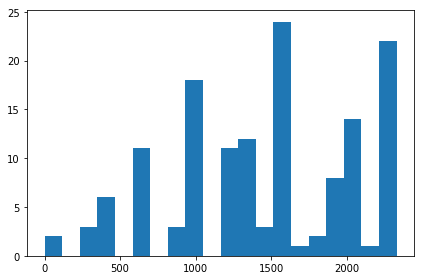

In [5]:
x_proj = [round(rect[1]+rect[3]//2) for rect in rects]
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
axs.hist(x_proj, bins=20)

In [6]:
print('#---- Line Cluster & Remove Outliers ----#')
from sklearn.cluster import KMeans

def get_cluster_label(rects):
    estimator = KMeans(n_clusters=9)
    estimator.fit([[rect[1]+rect[3]/2, 0] for rect in rects])
    return estimator.labels_

labels = get_cluster_label(rects)

def get_label_of_outlier(labels):
    uni, unic = np.unique(labels, return_counts=True)
    print("uni: ", uni)
    print("unic: ", unic)
    labels_of_outlier = uni[unic < 4]
    print("labels_of_outlier: ", labels_of_outlier)
    return labels_of_outlier

labels_of_outlier = get_label_of_outlier(labels)

def is_outlier(idx):
    label = labels[idx]
    return (labels_of_outlier == label).any()

loop = 0
while len(labels_of_outlier) != 0:
    loop += 1
    print('REMOVE ', loop, ': remove outlier in clusters...')
    rects = [rect for idx, rect in enumerate(rects) if not is_outlier(idx)]
    print('', len(rects), ' rects last.\n--')
    labels = get_cluster_label(rects)
    labels_of_outlier = get_label_of_outlier(labels)

print('[Finished.]')
print(len(rects), ' rects last.')
print('#---- Line Cluster & Remove Outliers ----#')

#---- Line Cluster & Remove Outliers ----#
uni:  [0 1 2 3 4 5 6 7 8]
unic:  [23 11  9 25 11 21 24 15  2]
labels_of_outlier:  [8]
REMOVE  1 : remove outlier in clusters...
 139  rects last.
--
uni:  [0 1 2 3 4 5 6 7 8]
unic:  [21 14 15  9 23 25 11 11 10]
labels_of_outlier:  []
[Finished.]
139  rects last.
#---- Line Cluster & Remove Outliers ----#


## Sort Line

In [7]:
labels

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3,
       3], dtype=int32)

In [8]:
print('#---- Sort Lines ----#')

uni = np.unique(labels)
idxes = np.unique(labels, return_index=True)[1]
lines_in_label = [labels[idx] for idx in sorted(idxes, reverse=True)]
print('lines_in_label: ', lines_in_label)

rects_in_line = []
rects_ = np.asarray(rects)
for i in range(9):
    print('Sort line', i)
    line = sorted(rects_[labels == lines_in_label[i]], key=lambda item: item[0])
    rects_in_line.append(line)
    
print('#---- Sort Lines ----#')

#---- Sort Lines ----#
lines_in_label:  [3, 6, 0, 7, 2, 5, 8, 1, 4]
Sort line 0
Sort line 1
Sort line 2
Sort line 3
Sort line 4
Sort line 5
Sort line 6
Sort line 7
Sort line 8
#---- Sort Lines ----#


## Digit Cluster

In [34]:
def digit_cluster(rects_in_line, line_num):
    line = rects_in_line[line_num]
    print('--- Clustering line', line_num, '...')
    print(line)
    n_in_line = [8, 11, 18, 8, 11, 18, 8, 11, 18]

    def get_digit_cluster_label(rects, n):
        estimator = KMeans(n_clusters=n)
        estimator.fit([[rect[0]+rect[2]/2, 0] for rect in rects])
        return estimator.labels_
    
    labels = get_digit_cluster_label(line, n_in_line[line_num])
    print('labels: ', labels)

    def get_label_of_overlayed(labels):
        uni, unic = np.unique(labels, return_counts=True)
        print("uni: ", uni)
        print("unic: ", unic)
        labels_of_overlayed = uni[unic > 1]
        print("labels_of_overlayed: ", labels_of_overlayed)
        return labels_of_overlayed

    labels_of_overlayed = get_label_of_overlayed(labels)
    print('labels_of_overlayed: ', labels_of_overlayed)

    def is_overlayed(idx):
        label = labels[idx]
        return (labels_of_overlayed == label).any()

    def merge_rects(rects):
        x = min([rect[0] for rect in rects])
        y = min([rect[1] for rect in rects])
        w = max([rect[0] - x + rect[2] for rect in rects])
        h = max([rect[1] - y + rect[3] for rect in rects])
        return np.asarray([x, y, w, h])
    
    
    print('Merge Rects...')
    '''
    Two Methods of merging
    '''

    # No.1 Naive 1 Round
    print('[Naive 1 Round Mergeing]')
    new_rects = []
    for label in labels_of_overlayed:
        print('- Merging rect with label', label, '...')
        overlayeds = np.asarray(line)[labels == label]
        print('Merge:')
        print(overlayeds)
        print('into:')
        new_rect = merge_rects(overlayeds)
        print(new_rect)
        new_rects.append(new_rect)
    line = [rect for idx, rect in enumerate(line) if not is_overlayed(idx)]
    line = line + new_rects
    line.sort(key=lambda item: item[0])


    # No.2 Iteration
    # loop = 0
    # while len(labels_of_overlayed) != 0:
    #     loop += 1
    #     print('### REMOVE ', loop, ': merging digits...')


    #     print('### ', len(line), ' rects last.')
    #     labels = get_cluster_label(rects)
    #     labels_of_outlier = get_label_of_outlier(labels)

    # print('######## Finished.')
    
    print('Line', line_num, ' clustered.')
    print(line)
    return line

In [40]:
print('#---- Digit Cluster ----#')
lines = []
for line_num in range(9):
    new_line = digit_cluster(rects_in_line, line_num)
    save_drawn_rects(src_img.copy(), new_line, 'line' + str(line_num))
    lines.append(new_line)
print('#---- Digit Cluster ----#')

#---- Digit Cluster ----#
--- Clustering line 0 ...
[array([330, 340,  12,  42]), array([341, 272,  14,  67]), array([458, 289,  64,  93]), array([603, 294,  59, 106]), array([751, 299,  75, 111]), array([959, 317,  14,  93]), array([1108,  318,   61,   79]), array([1292,  326,   61,   78]), array([1452,  307,   59,  173])]
labels:  [0 0 7 5 3 2 4 1 6]
uni:  [0 1 2 3 4 5 6 7]
unic:  [2 1 1 1 1 1 1 1]
labels_of_overlayed:  [0]
labels_of_overlayed:  [0]
Merge Rects...
[Naive 1 Round Mergeing]
- Merging rect with label 0 ...
Merge:
[[330 340  12  42]
 [341 272  14  67]]
into:
[330 272  25 110]
Line 0  clustered.
[array([330, 272,  25, 110]), array([458, 289,  64,  93]), array([603, 294,  59, 106]), array([751, 299,  75, 111]), array([959, 317,  14,  93]), array([1108,  318,   61,   79]), array([1292,  326,   61,   78]), array([1452,  307,   59,  173])]
--- Clustering line 1 ...
[array([295, 604,  21, 108]), array([409, 625,  73,  85]), array([565, 641,  67,  78]), array([695, 655,  70,  6

labels:  [3 3 0 4 4 5 2 7 1 6]
uni:  [0 1 2 3 4 5 6 7]
unic:  [1 1 1 2 2 1 1 1]
labels_of_overlayed:  [3 4]
labels_of_overlayed:  [3 4]
Merge Rects...
[Naive 1 Round Mergeing]
- Merging rect with label 3 ...
Merge:
[[ 257 1822   15   81]
 [ 270 1813    3    8]]
into:
[ 257 1813   16   90]
- Merging rect with label 4 ...
Merge:
[[ 514 1902   11    9]
 [ 523 1840   37   71]]
into:
[ 514 1840   46   71]
Line 6  clustered.
[array([ 257, 1813,   16,   90]), array([ 371, 1829,   60,   79]), array([ 514, 1840,   46,   71]), array([ 651, 1845,   48,   75]), array([ 798, 1850,   18,   77]), array([ 886, 1860,   43,   57]), array([1014, 1862,   47,   56]), array([1135, 1843,   45,  120])]
--- Clustering line 7 ...
[array([ 252, 1993,   18,   77]), array([ 357, 2069,   19,   12]), array([ 366, 2008,   41,   73]), array([ 395, 2012,   31,    6]), array([ 483, 2015,   70,   68]), array([ 630, 2028,   44,   43]), array([ 753, 2020,   16,   64]), array([ 863, 2018,   20,   64]), array([ 981, 2016,   

In [44]:
new_line = digit_cluster(rects_in_line, 2)
save_drawn_rects(src_img.copy(), new_line, 'line' + str(2))

--- Clustering line 2 ...
[array([  0, 926,   2,   9]), array([  0, 912,   2,   5]), array([267, 872,  59, 103]), array([379, 898,  59,  80]), array([509, 909,  13,  73]), array([602, 901,  43,  78]), array([702, 916,  30,  45]), array([799, 899,   9,  90]), array([888, 907,  10,  80]), array([951, 899,  41,  86]), array([1067,  895,   38,   82]), array([1163,  900,   43,  100]), array([1261,  921,   38,   46]), array([1342,  908,   29,   86]), array([1411,  928,   36,   51]), array([1486,  923,   45,   68]), array([1593,  933,   38,   51]), array([1662,  937,   48,   64]), array([1711,  944,   12,    3]), array([1773,  932,   47,   70]), array([1890,  936,   10,   85])]
labels:  [ 4  4 10  1 11  9  2 15 17  7 14  5 16  3  3 13  0 12 12  8  6]
uni:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
unic:  [1 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1]
labels_of_overlayed:  [ 3  4 12]
labels_of_overlayed:  [ 3  4 12]
Merge Rects...
[Naive 1 Round Mergeing]
- Merging rect with label 3 ...
M

# Test

In [79]:
# Load the classifier
clf = joblib.load("model/digits_cls.pkl")

num_img = src_img.copy()
# For each rectangular region, calculate HOG features and predict
# the digit using Linear SVM.
for rect in line:
    # Make the rec tangular region around the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = th_img[pt1:pt1+leng, pt2:pt2+leng]
#     rois.append(roi)
# for roi in rois:
    if roi.size <= 20: continue
#     cv2.imwrite('inter/roi-s.jpg', roi)
    # Resize the image
    roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
#     cv2.imwrite('inter/roi.jpg', roi)
    roi = cv2.dilate(roi, (3, 3))
#     cv2.imwrite('inter/roi-d.jpg', roi)

    # Calculate the HOG features
    roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
#     print('predict: ', nbr)
    cv2.putText(num_img, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, 150, 3)
    
cv2.imwrite('inter/num.jpg', num_img)

predict:  [1]
predict:  [5]
predict:  [3]
predict:  [3]
predict:  [1]
predict:  [0]
predict:  [0]
predict:  [7]


/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


True

In [42]:
clf = joblib.load("model/digits_cls.pkl")
# def pred_line(line, clf):
for idx, line in enumerate(lines):
    num_img = src_img.copy()
    # For each rectangular region, calculate HOG features and predict
    # the digit using Linear SVM.
    for rect in line:
        # Make the rec tangular region around the digit
        leng = int(rect[3] * 1.6)
        pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
        pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
        roi = th_img[pt1:pt1+leng, pt2:pt2+leng]
    #     rois.append(roi)
    # for roi in rois:
        if roi.size <= 20: continue
        cv2.imwrite('inter/roi-s.jpg', roi)
        # Resize the image
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        cv2.imwrite('inter/roi.jpg', roi)
        roi = cv2.dilate(roi, (3, 3))
        cv2.imwrite('inter/roi-d.jpg', roi)

        # Calculate the HOG features
        roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
        nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
        # print('predict: ', nbr)
        cv2.putText(num_img, str(int(nbr[0])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 2, 150, 3)

    cv2.imwrite('inter/line' + str(idx) + 'pred.jpg', num_img)

/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/usr/local/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)
